# 1.Simulaiton: Housing data set

Reference: https://medium.com/@nlztrk/stratification-on-regression-problems-e36b3b866079 

Description: 
* Using imbalance real, housing data set downloaded from kaggle  
* Taking samples from the dataset with preserving the proportions of the classes in both splits (training and test) by stratification and comparing it to random splitting
* No regressor fitted on data, just visual inspection of distribution of train-test split
* Stratification based on quantiles with pd.qcut

### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import numpy as np


# current wroking directory
import os
os.getcwd()

'/Users/nadja/Documents/University/Master_Statistik/WS2023_24/SLDS/slds_stratification/Simulations'

In [2]:
import warnings
warnings.filterwarnings('ignore')

Load data: “Housing Prices Competition” data from Kaggle

In [5]:
train_df = pd.read_csv("./data/train.csv")
print(train_df.shape)
labels = train_df["SalePrice"]
print("Unique label count:", labels.nunique())
print("Data length:", len(train_df), "rows")
print("First 10 labels:", labels[0:10])

(1460, 81)
Unique label count: 663
Data length: 1460 rows
First 10 labels: 0    208500
1    181500
2    223500
3    140000
4    250000
5    143000
6    307000
7    200000
8    129900
9    118000
Name: SalePrice, dtype: int64


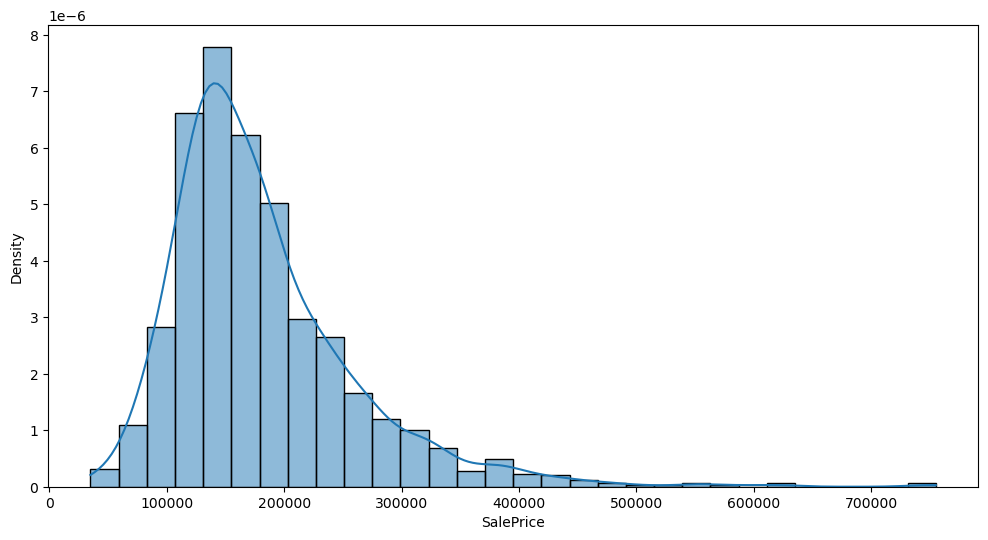

In [24]:
plt.figure(figsize=(12,6))
_ = sns.histplot(data=labels, kde=True, stat="density", bins=30)

In [22]:
def fold_visualizer(data, fold_idxs, seed_num):
    fig, axs = plt.subplots(len(fold_idxs)//2, 2, figsize=(15,(len(fold_idxs)//2)*5))
    fig.suptitle("Seed: " + str(seed_num), fontsize=16)
    for fold_id, (train_ids, val_ids) in enumerate(fold_idxs):
        sns.histplot(data=data[train_ids],
                     kde=True,
                     stat="density",
                     alpha=0.15,
                     label="Train Set",
                     bins=30,
                     line_kws={"linewidth":4},
                     ax=axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)])
        sns.histplot(data=data[val_ids],
                     kde=True,
                     stat="density", 
                     color="darkorange",
                     alpha=0.15,
                     label="Validation Set",
                     bins=30,
                     line_kws={"linewidth":4},
                     ax=axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)])
        axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)].legend()
        axs[fold_id%(len(fold_idxs)//2), fold_id//(len(fold_idxs)//2)].set_title("Split " + str(fold_id+1))
    plt.show()
    

### Classical KFold from scikit-learn
Link: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html 

Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds. Each fold is then used once as a validation while the k - 1 remaining folds form the training set. 

Kfold: used to generate indices for splitting a dataset into train and test sets during cross-validation.

Output Kfold.split(labels): Each fold is represented by a tuple of two arrays. The first array contains the indices for the training set, and the second array contains the indices for the test set.

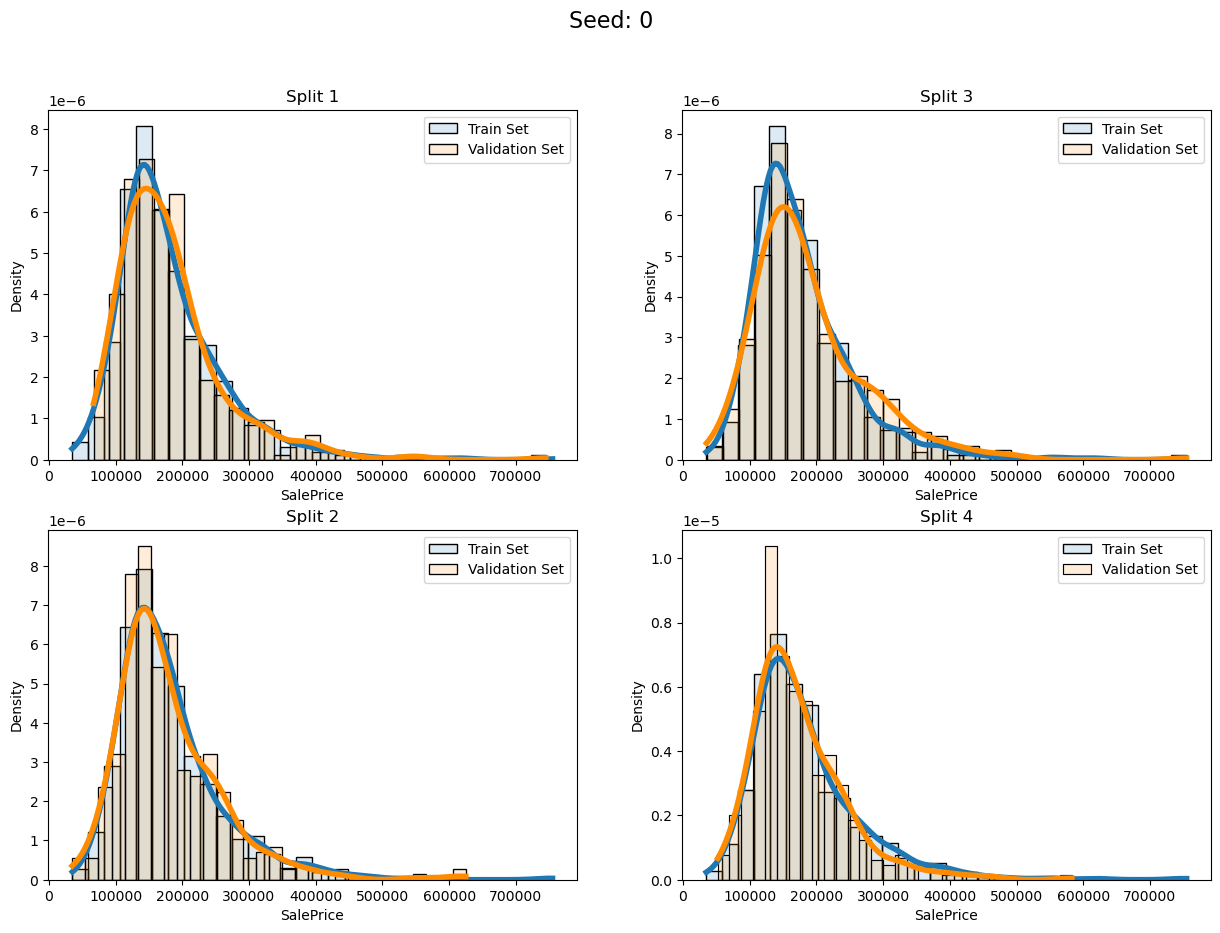

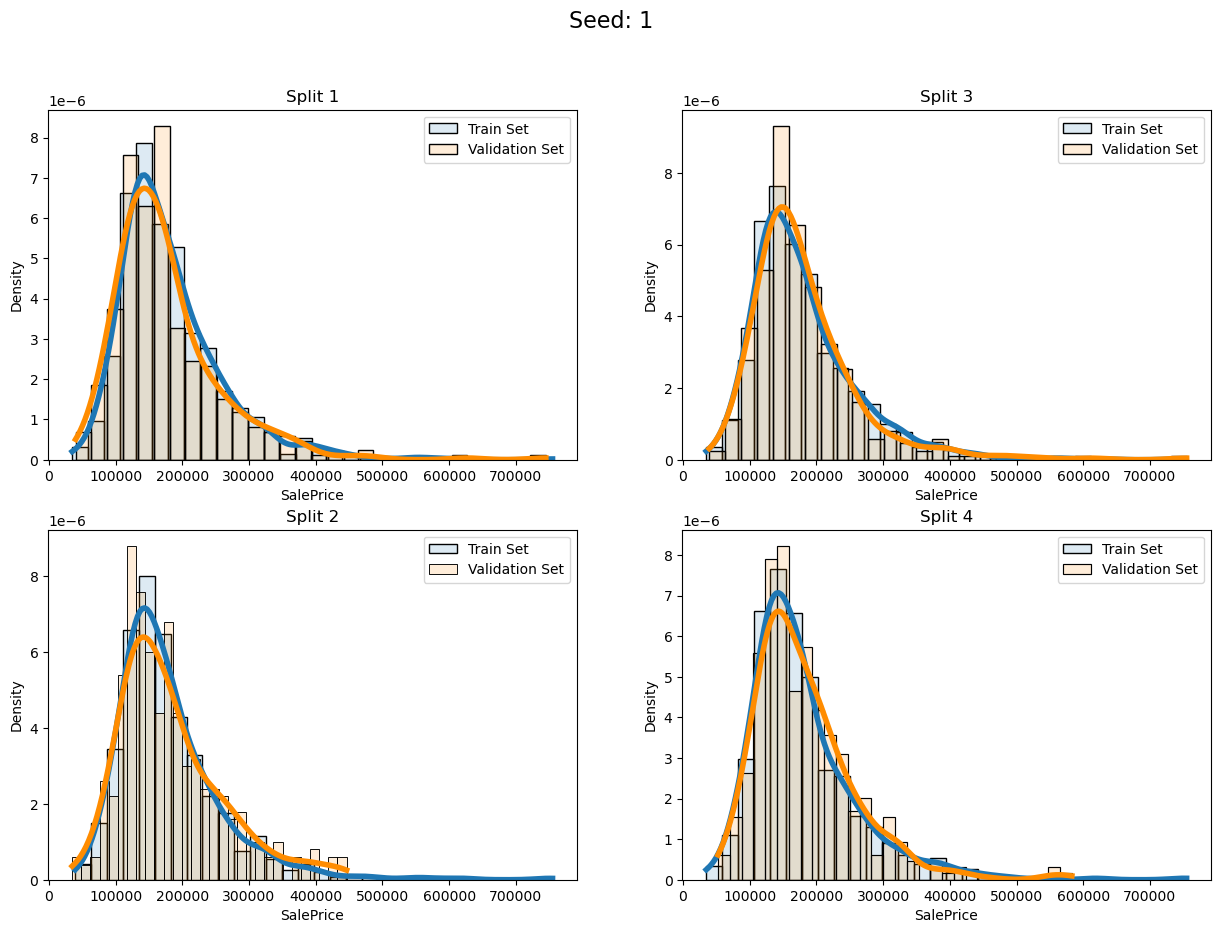

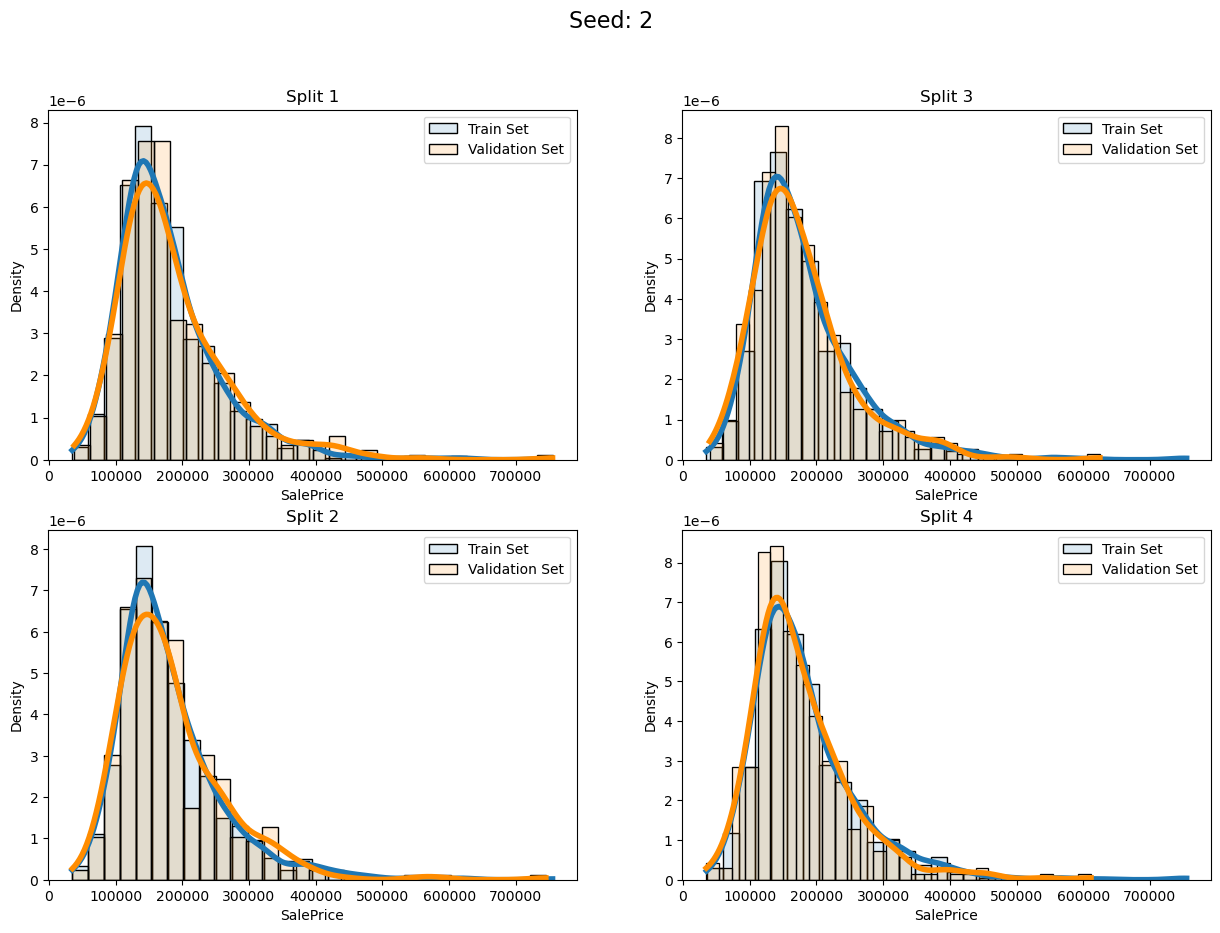

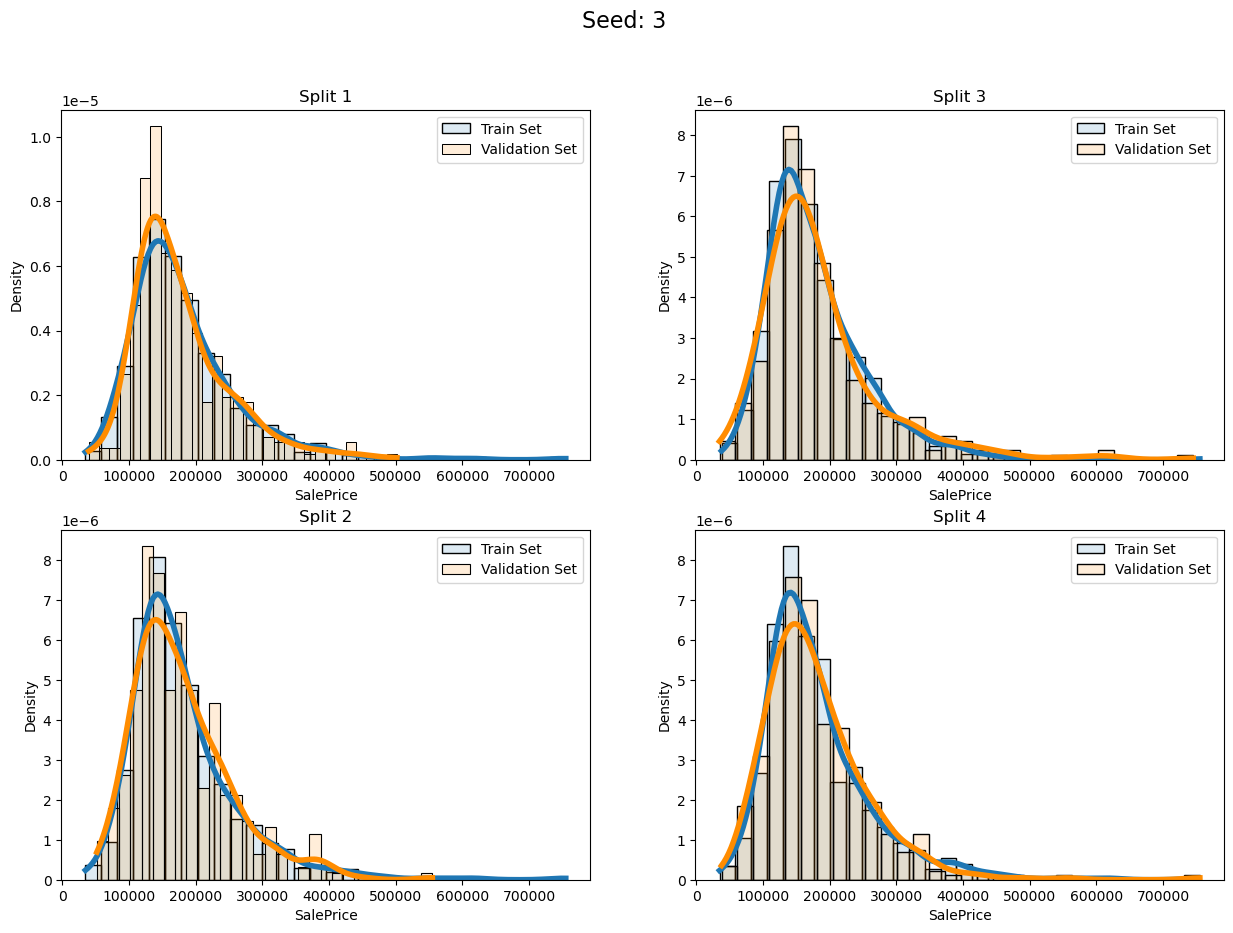

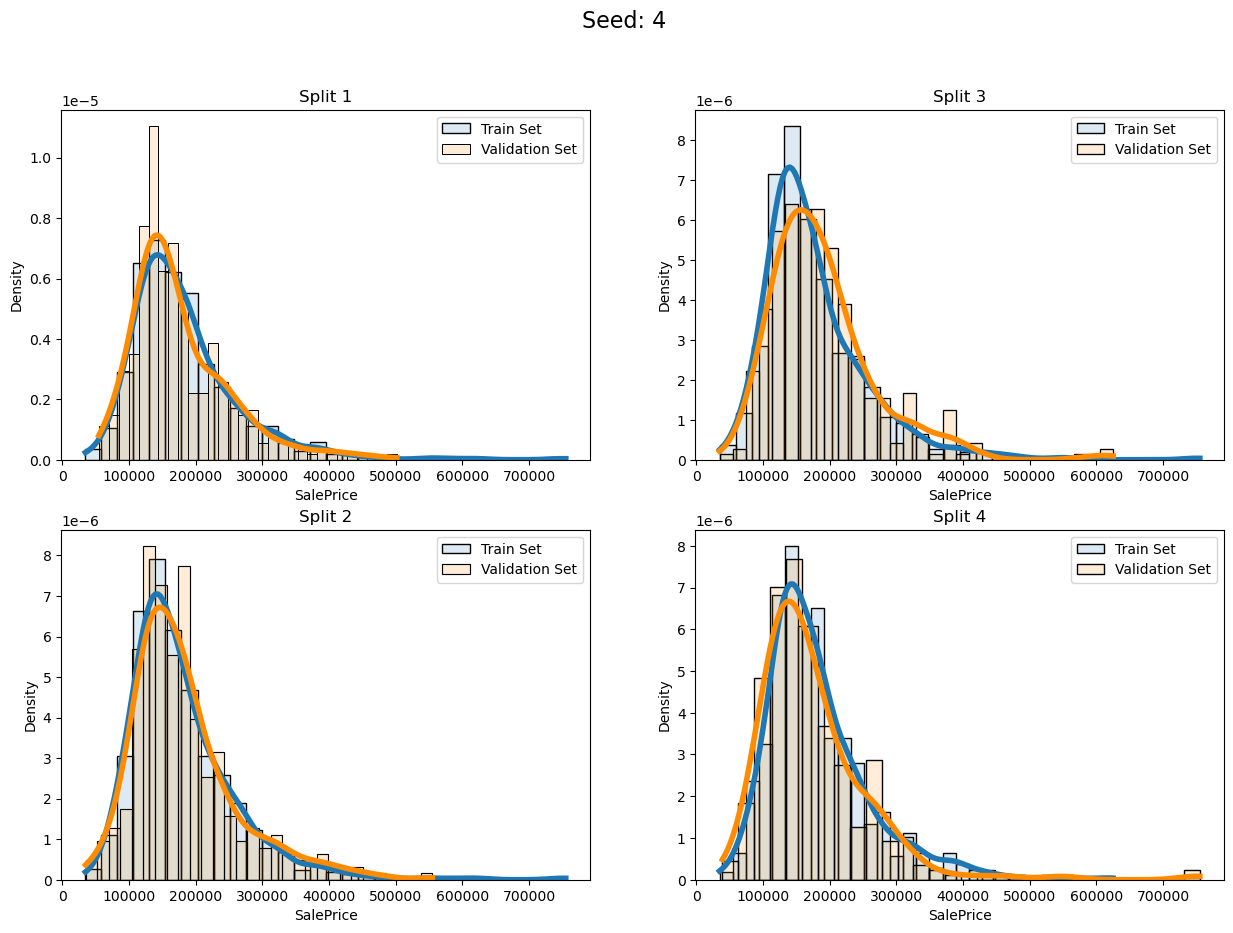

In [23]:
for i in range(5):
    baseline_kfold = list(KFold(4,
                                shuffle=True,
                                random_state=i
                               ).split(labels))
    fold_visualizer(data=labels,
                    fold_idxs=baseline_kfold,
                    seed_num=i)
                

In [59]:
#have a look at KFold
# 1460 observaitons ind data
# number of folds
print("number of folds:", len(baseline_kfold))

# have a look at first fold
print("first fold elemnts:", len(baseline_kfold[0]))
print("first fold training:", len(baseline_kfold[0][0]))
print("first fold testing:", len(baseline_kfold[0][1]))
print("first fold total:", len(baseline_kfold[0][1]) + len(baseline_kfold[0][0]))

print("first fold training:", baseline_kfold[0][0][0:10], "...", baseline_kfold[0][0][-10:])
print("first fold testing:",baseline_kfold[0][1][0:10], "...",baseline_kfold[0][1][-10:])


number of folds: 4
first fold elemnts: 2
first fold training: 1095
first fold testing: 365
first fold total: 1460
first fold training: [ 0  1  2  3  4  6  7  8  9 12] ... [1449 1451 1452 1453 1454 1455 1456 1457 1458 1459]
first fold testing: [ 5 10 11 13 15 26 29 31 33 35] ... [1422 1423 1424 1433 1436 1440 1441 1445 1447 1450]


### Implement stratificaton in corssvalidation 
* StratifiedKFold for classification: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
* pandas.qcut: Quantile-based discretization function, https://pandas.pydata.org/docs/reference/api/pandas.qcut.html

In [ ]:
def create_cont_folds(df, n_s=8, n_grp=1000, seed=1):
    # StratifiedKFold for classification
    skf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=seed)
    #pandas.qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise'
    # q = Number of quantiles
    grp = pd.qcut(x = df, q = n_grp, labels=False)
    target = grp
    
    fold_nums = np.zeros(len(df))
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        fold_nums[v] = fold_no
    
    cv_splits = []

    for i in range(num_of_folds):
        test_indices = np.argwhere(fold_nums==i).flatten()
        train_indices = list(set(range(len(labels))) - set(test_indices))
        cv_splits.append((train_indices, test_indices))
        
    return cv_splits


In [ ]:
df = labels # labels
n_s=4 # number of folds
n_grp=10 # number of groups

seed=1 # set seed


# StratifiedKFold for classification
skf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=seed)
# create groups
grp = pd.qcut(df, n_grp, labels=False)
target = grp

# create fold numbers    
fold_nums = np.zeros(len(df))
for fold_no, (t, v) in enumerate(skf.split(target, target)):
    fold_nums[v] = fold_no
#print("fold_nums", fold_nums)
    
cv_splits = []

for i in range(num_of_folds):
    test_indices = np.argwhere(fold_nums==i).flatten()
    train_indices = list(set(range(len(labels))) - set(test_indices))
    cv_splits.append((train_indices, test_indices))
        
#cv_splits

In [95]:
print(len(grp))
print(grp.unique().max())
print(np.sort(grp.unique()))
print(grp.value_counts())

1460
9
[0 1 2 3 4 5 6 7 8 9]
SalePrice
3    150
7    149
1    149
6    146
0    146
9    145
8    144
2    144
5    144
4    143
Name: count, dtype: int64


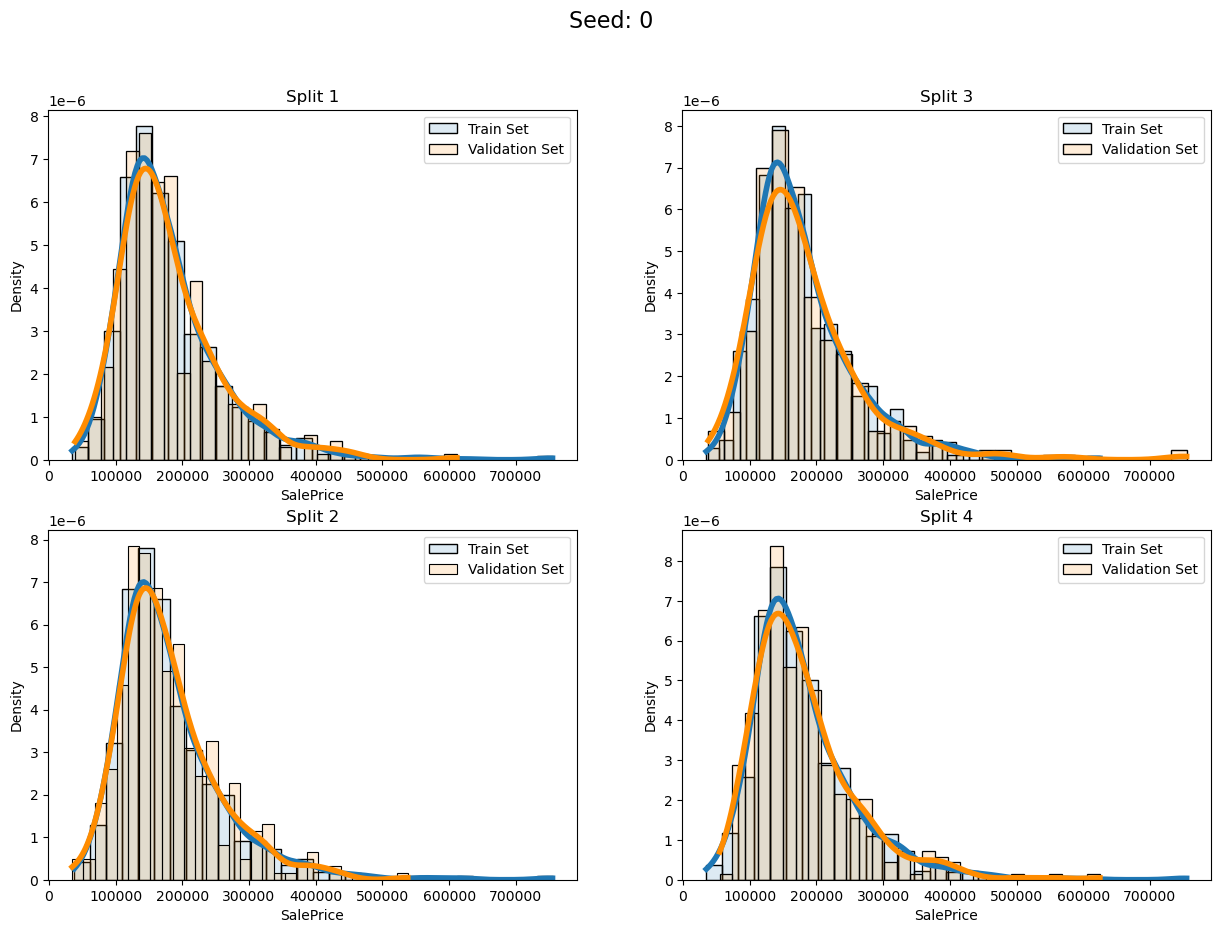

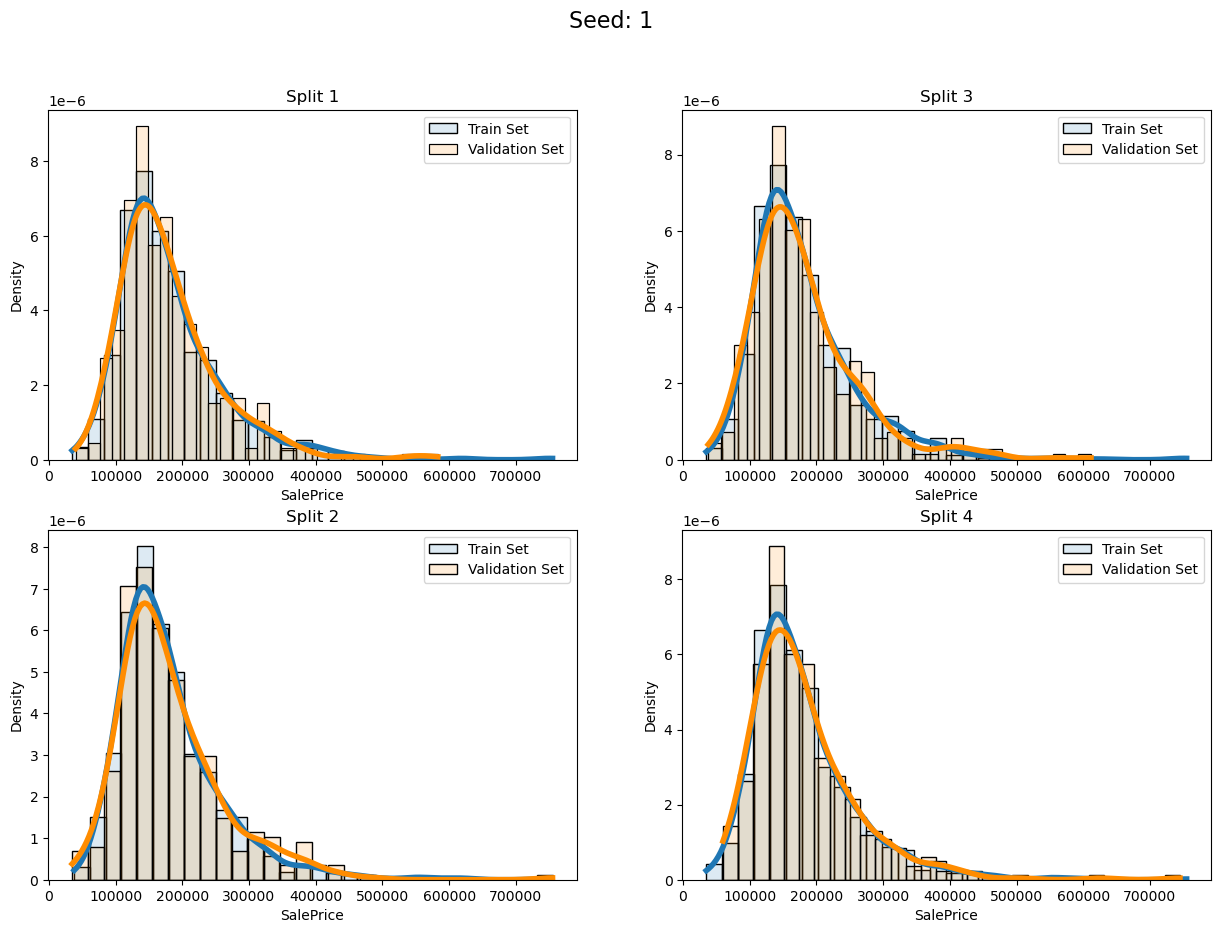

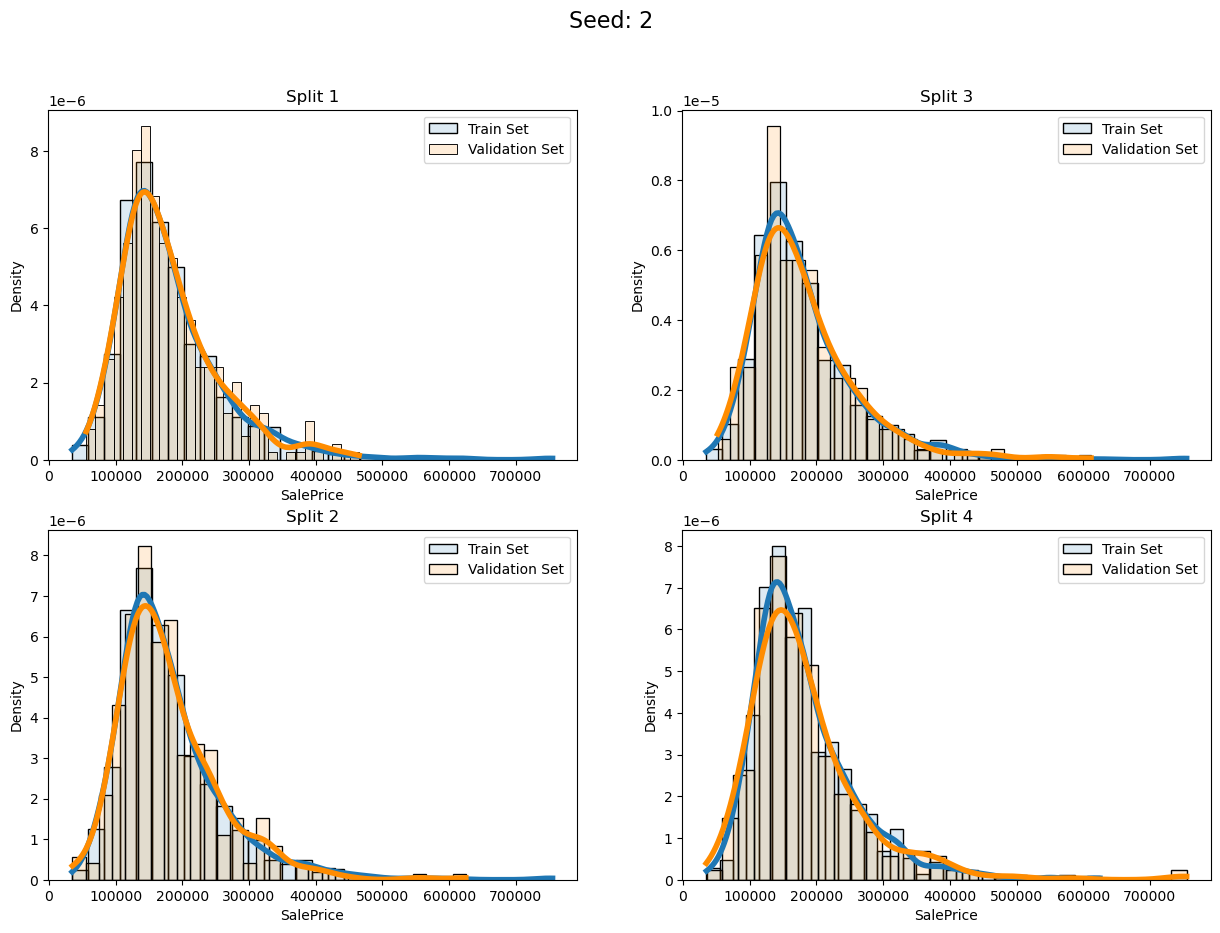

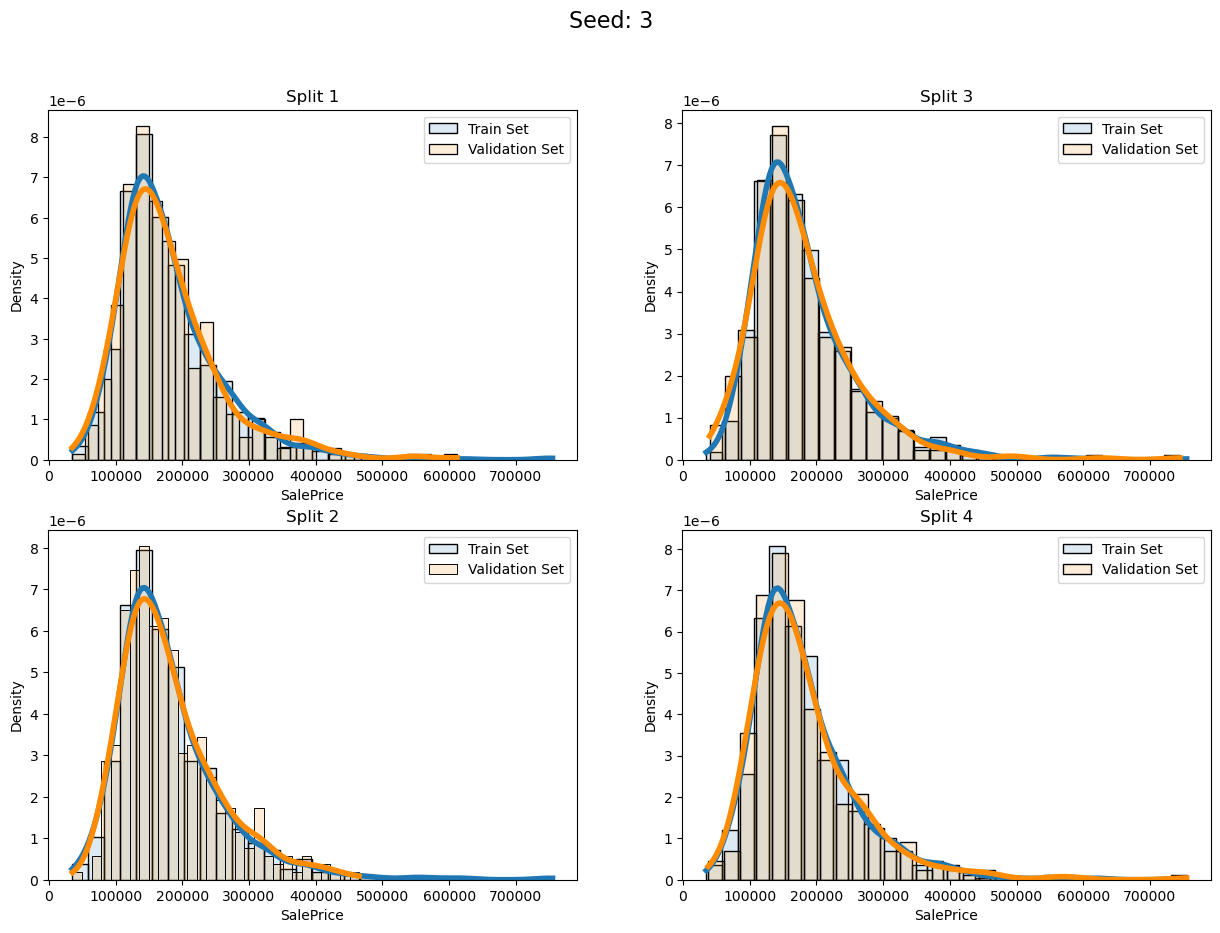

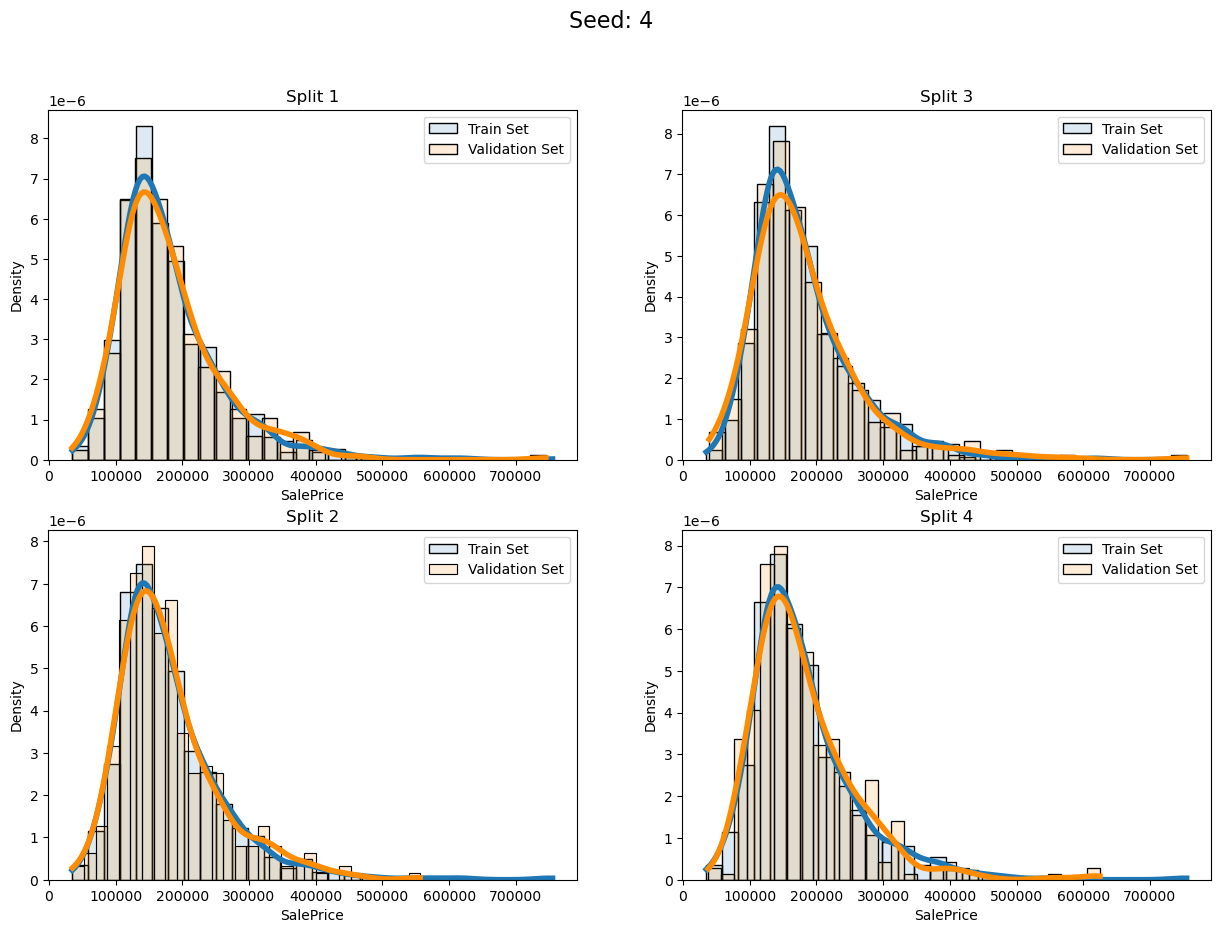

In [96]:
num_of_folds = 4
num_of_groups = 10

for i in range(5):
    cv_splits = create_cont_folds(labels, n_s=num_of_folds, n_grp=num_of_groups, seed=i)
    fold_visualizer(data=labels,
                    fold_idxs=cv_splits,
                    seed_num=i)

In [98]:
#have a look at cv_splits
# 1460 observaitons ind data
# number of folds
print("number of folds:", len(cv_splits))

# have a look at first fold
print("first fold elemnts:", len(cv_splits[0]))
print("first fold training:", len(cv_splits[0][0]))
print("first fold testing:", len(cv_splits[0][1]))
print("first fold total:", len(cv_splits[0][1]) + len(cv_splits[0][0]))

print("first fold training:", cv_splits[0][0][0:10], "...", cv_splits[0][0][-10:])
print("first fold testing:",cv_splits[0][1][0:10], "...",cv_splits[0][1][-10:])


number of folds: 4
first fold elemnts: 2
first fold training: 1095
first fold testing: 365
first fold total: 1460
first fold training: [1, 3, 4, 5, 7, 9, 10, 11, 12, 15] ... [1447, 1449, 1450, 1452, 1453, 1455, 1456, 1457, 1458, 1459]
first fold testing: [ 0  2  6  8 13 14 16 21 27 28] ... [1426 1428 1433 1438 1439 1440 1446 1448 1451 1454]
